In [1]:
!pip install matplotlib numpy pandas scikit-learn dask "dask[dataframe]"

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import dask.dataframe as dd
import sklearn as skl
from sklearn.decomposition import PCA

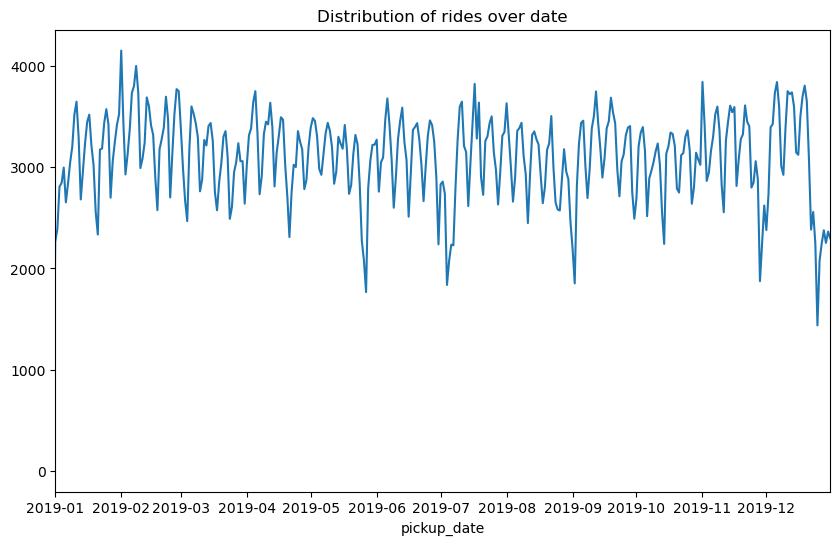

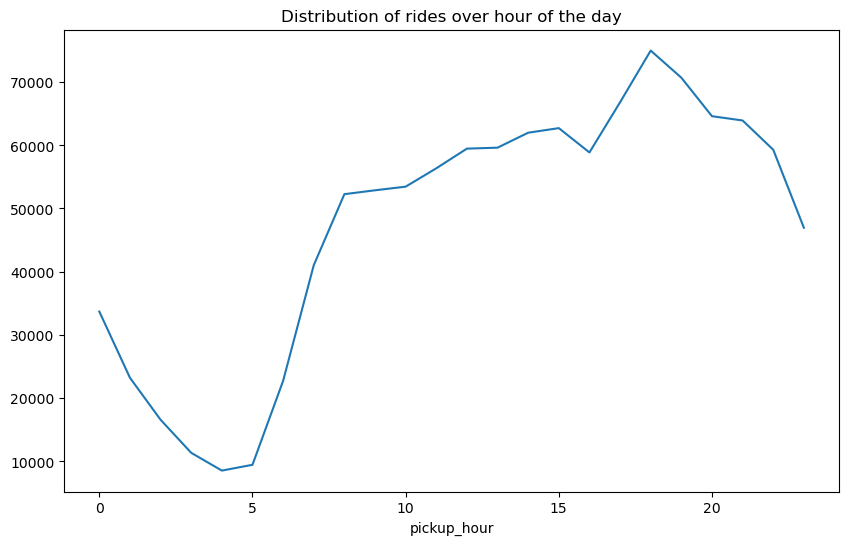

In [3]:
dataset = 'Datasets/2019new.csv'

if os.path.exists(dataset):
    # Load the CSV using dask for parallel processing
    df = dd.read_csv(dataset).compute()
    
    # If 'congestion_surcharge' column has NaNs, set them to 0
    df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0)
    df = df.dropna()

    # Drop rows where 'trip_distance' is 0 and 'fare_amount' is <= 0
    df = df.drop(df[(df['trip_distance'] == 0)].index)
    df = df.drop(['total_amount'], axis=1)
    df = df.drop(['extra'], axis=1)
    df = df.drop(['mta_tax'], axis=1)
    df = df.drop(['tip_amount'], axis=1)
    df = df.drop(['tolls_amount'], axis=1)
    df = df.drop(['improvement_surcharge'], axis=1)
    df = df.drop(['congestion_surcharge'], axis=1)
    df = df.drop(['store_and_fwd_flag'], axis=1)
    df = df.drop(['payment_type'], axis=1)
    df = df[df['fare_amount'] > 0]
    df = df[df['fare_amount'] <= 50]

    # Convert 'tpep_pickup_datetime' to datetime and extract date and hour
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

    # Drop unneeded columns
    df = df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

    # Plotting distribution of rides over date
    plt.figure(figsize=(10, 6))
    df['pickup_date'].value_counts().sort_index().plot().set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-12-31'))
    plt.title('Distribution of rides over date')
    plt.show()

    # Plotting distribution of rides over hour of the day
    plt.figure(figsize=(10, 6))
    df['pickup_hour'].value_counts().sort_index().plot()
    plt.title('Distribution of rides over hour of the day')
    plt.show()
else:
    print("Dataset not found")


In [4]:
weather = pd.read_csv('Datasets/weather.csv')

weather=weather.drop(columns=['tmax','tmin','departure','HDD','CDD'])
weather['date'] = pd.to_datetime(weather['date'])

holidays = pd.read_csv('Datasets/USHoliday.csv')

#maintain only if holiday is in 2019
holidays['Date'] = pd.to_datetime(holidays['Date'])
holidays=holidays[holidays['Date'].dt.year==2019]

#set precipitation to 0 if NaN and integer, new_snow, snow_depth
weather['precipitation'] = weather['precipitation'].replace(to_replace="T", value=0)
weather['new_snow'] = weather['new_snow'].replace(to_replace="T", value=0)
weather['snow_depth'] = weather['snow_depth'].replace(to_replace="T", value=0)

#set to float
weather['precipitation'] = weather['precipitation'].astype(float)
weather['new_snow'] = weather['new_snow'].astype(float)
weather['snow_depth'] = weather['snow_depth'].astype(float)

# Ensure the pickup_date column is in datetime64[ns] format
df['pickup_date'] = pd.to_datetime(df['pickup_date'])

new_df = pd.merge(df, weather, how='left', left_on='pickup_date', right_on='date')

new_df = new_df.drop(['date'], axis=1)
#add column 1 if week day, 2 if weekend, 3 if holiday
new_df['holiday'] = new_df['pickup_date'].isin(holidays['Date']).astype(int)
new_df['day_of_week'] = new_df['pickup_date'].dt.dayofweek
new_df['day_type'] = np.where(new_df['day_of_week'] < 5, 1, 2)
new_df.loc[new_df['holiday'] == 1, 'day_type'] = 3
new_df = new_df.drop(['pickup_date'], axis=1)
new_df = new_df.drop(['day_of_week'], axis=1)
new_df = new_df.drop(['holiday'], axis=1)
new_df = new_df.dropna()

C:\Users\tomma\AppData\Local\Temp\ipykernel_14048\2287615902.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather['date'] = pd.to_datetime(weather['date'])


In [5]:
zones = pd.read_csv('Datasets/taxi_zone_lookup.csv')
zones = zones.drop(['Borough'], axis=1)
zones = zones.drop(['Zone'], axis=1)

zones = zones[zones['service_zone'] != 'N/A']

# Replace 'EWR' with 'Airports' in the 'service_zone' column
zones['service_zone'] = zones['service_zone'].replace('EWR', 'Airports')

# Merge taxi_zone_lookup.csv with the new dataset on 'pulocationid' and 'dolocationid'
pulocation = new_df.merge(zones[['LocationID', 'service_zone']], left_on='pulocationid', right_on='LocationID', how='left')
dolocation = pulocation.merge(zones[['LocationID', 'service_zone']], left_on='dolocationid', right_on='LocationID', how='left', suffixes=('_pulocation', '_dolocation'))

# Create a new column 'zone_type' based on the conditions
def get_zone_type(row):
    service_zone_pulocation = row['service_zone_pulocation']
    service_zone_dolocation = row['service_zone_dolocation']

    if service_zone_pulocation == 'Airports' or service_zone_dolocation == 'Airports':
        return 1
    elif 'Boro Zone' in [service_zone_pulocation, service_zone_dolocation]:
        return 2
    elif 'Yellow Zone' in [service_zone_pulocation, service_zone_dolocation]:
        return 3
    else:
        return None

# Apply the zone_type function to the merged dataframe
dolocation['zone_type'] = dolocation.apply(get_zone_type, axis=1)

# Remove rows where 'zone_type' is None (rows that don't meet any of the conditions)
new_df = dolocation.dropna(subset=['zone_type'])

new_df = new_df.drop(['pulocationid'], axis=1)
new_df = new_df.drop(['dolocationid'], axis=1)
new_df = new_df.drop(['LocationID_pulocation'], axis=1)
new_df = new_df.drop(['service_zone_pulocation'], axis=1)
new_df = new_df.drop(['LocationID_dolocation'], axis=1)
new_df = new_df.drop(['service_zone_dolocation'], axis=1)
new_df = new_df.drop(['tavg'], axis=1)
new_df = new_df.drop(['precipitation'], axis=1)
new_df = new_df.drop(['new_snow'], axis=1)
new_df = new_df.drop(['snow_depth'], axis=1)

print(new_df.head(1))
print(new_df.shape)

   vendorid  passenger_count  trip_distance  ratecodeid  fare_amount  \
0       2.0              2.0           6.69         1.0         26.5   

   pickup_hour  day_type  zone_type  
0           19         2        2.0  
(1124454, 8)


In [ ]:
X = new_df.drop(['fare_amount'], axis=1)
y = new_df['fare_amount']

In [7]:
#LINEAR REGRESSOR MODEL
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(score)

0.900864577267613


R^2 score:  0.8941776189820482


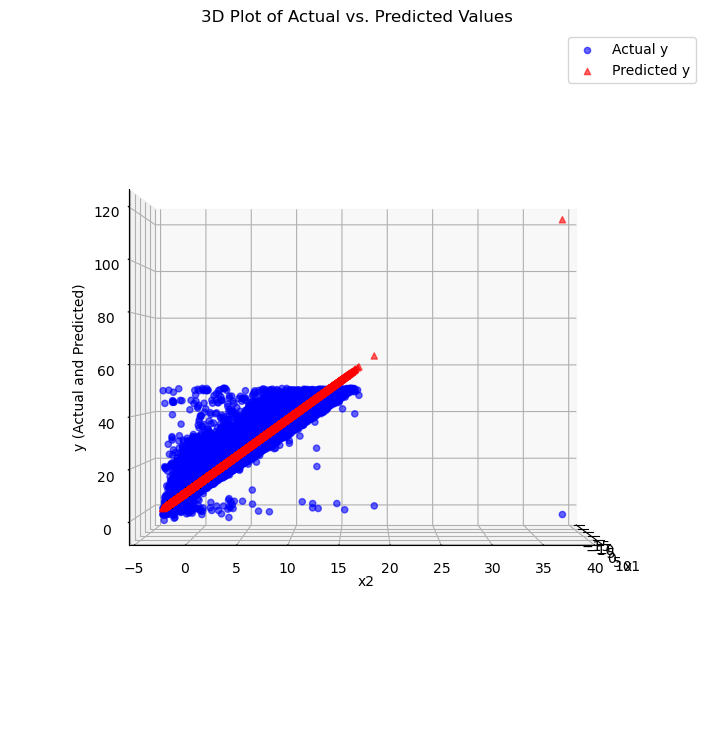

In [26]:
pca = PCA(n_components=2)  # You can specify less if you want to reduce dimensions
# Fit and transform the data
X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

second_linearRegressor = LinearRegression()
second_linearRegressor.fit(X_train_pca, y_train)

y_pred= second_linearRegressor.predict(X_test_pca)

score = second_linearRegressor.score(X_test_pca, y_test)
print("R^2 score: ", score)

x1 = X_test_pca[:, 0]  # First component of X_test_pca
x2 = X_test_pca[:, 1]  # Second component of X_test_pca

# Initialize a 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot actual values
ax.scatter(x1, x2, y_test, c='blue', label='Actual y', alpha=0.6, marker='o')

# Plot predictions
ax.scatter(x1, x2, y_pred, c='red', label='Predicted y', alpha=0.6, marker='^')

# Add labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y (Actual and Predicted)')
ax.set_title('3D Plot of Actual vs. Predicted Values')

ax.view_init(elev=0, azim=0)
# Add legend
ax.legend()

# Show plot
plt.show()



In [ ]:
#KNN MODEL
knnModel = KNeighborsRegressor(n_neighbors=3)
knnModel.fit(X_train, y_train)

score = knnModel.score(X_test, y_test)
print(score)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
iterations = 5
scores = []
for i in range(iterations):
  knnModel = KNeighborsRegressor(n_neighbors=(5+2*i))
  knnModel.fit(X_train, y_train)

  score = knnModel.score(X_test, y_test)
  scores.append(score)

print(scores)

In [ ]:
#ELASTICNET MODEL
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train1_scaled = scaler.fit_transform(X_train1)
X_test1_scaled = scaler.transform(X_test1)

scores = []

alpha_values = np.arange(0.5, 1.1, 0.1)  # 0.1 to 1 (inclusive), step of 0.1
l1_ratio_values = np.arange(0, 1.1, 0.2)  # 0 to 1 (inclusive), step of 0.1

for alpha in alpha_values:
    for l1_ratio in l1_ratio_values:
        print(f"Alpha: {alpha}, L1 Ratio: {l1_ratio}")
        eNet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42, max_iter=5000, tol=1e-3)
        eNet.fit(X_train1_scaled, y_train1)
        score = eNet.score(X_test1_scaled, y_test1)
        scores.append(score)
        print(f"Score: {score}")

print(scores)

scores_array = np.array(scores)
print(max(scores_array))

scores_array_reshaped = scores_array.reshape(len(alpha_values), len(l1_ratio_values))
print(scores_array_reshaped)    

vendorid                 float64
passenger_count          float64
trip_distance            float64
ratecodeid               float64
store_and_fwd_flag         int64
pulocationid             float64
dolocationid             float64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
pickup_minute              int64
tavg                     float64
precipitation            float64
new_snow                 float64
snow_depth               float64
day_type                   int64
dtype: object
0.999797527955203


C:\Users\tomma\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\tomma\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [ ]:
criteria = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

for criterion in criteria:
  treeRegressor = DecisionTreeRegressor(criterion=criterion, splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, random_state=42,)
  treeRegressor.fit(X_train1, y_train1)
  score = treeRegressor.score(X_test1, y_test1)
  print(f"Criterion: {criterion}, Score: {score}")

Criterion: squared_error, Score: 0.9031746628912442
Criterion: friedman_mse, Score: 0.9032391291699992
